In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import SVG, display
from keras.utils.vis_utils import model_to_dot
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, UpSampling2D, MaxPooling2D
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers
import cv2
import os
from keras.preprocessing.image import load_img
import numpy as np
os.environ["CUDA_VISIBLE_DEVICES"]="2"



Using TensorFlow backend.


In [2]:
filePath = "img_align_celeba/"
inputData = os.listdir(filePath)
img_shape = (176,224, 3)

def datagen(batchSize,filesList):
    while(True):
        files = np.random.choice(filesList,batchSize,replace=False)
        X_train = []
        for file in files:
            image = cv2.imread(filePath + "/" + file)
#             print(np.array(image).min(),np.array(image).max())
#             print(np.array(image).shape)
#             plt.imshow(image)
            image = cv2.resize(image,(176,224),interpolation = cv2.INTER_CUBIC)
            image = image / 255.0
            X_train.append(image)
        X_train = np.array(X_train)
        yield X_train
        
randomDim = 100
batchSize = 10
epochs = 1

In [3]:

np.random.seed(1000)



# Optimizer

In [4]:
adam = Adam(lr=0.0002, beta_1=0.5)

# Generator

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
GeneratorInput (Dense)       (None, 19712)             1990912   
_________________________________________________________________
reshape_1 (Reshape)          (None, 14, 11, 128)       0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 22, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 22, 16)        18448     
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 56, 44, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 44, 16)        2320      
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 112, 88, 16)       0         
__________

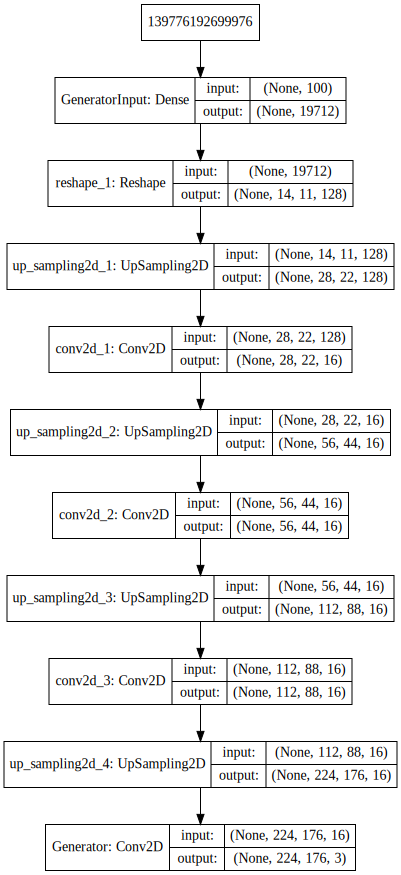

In [ ]:
generator = Sequential(name='Generator')
generator.add(Dense(128*14*11, input_dim=randomDim,name='GeneratorInput', activation='relu'))
# generator.add(LeakyReLU(0.2))
generator.add(Reshape((14, 11, 128)))

generator.add(UpSampling2D(size=(2, 2), interpolation='bilinear'))
generator.add(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'))
# generator.add(LeakyReLU(0.2))

generator.add(UpSampling2D(size=(2, 2), interpolation='bilinear'))
generator.add(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'))
# generator.add(LeakyReLU(0.2))

generator.add(UpSampling2D(size=(2, 2), interpolation='bilinear'))
generator.add(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'))

generator.add(UpSampling2D(size=(2, 2), interpolation='bilinear'))
generator.add(Conv2D(3, kernel_size=(3, 3), padding='same', activation='sigmoid',name='Generator'))
generator.compile(loss='binary_crossentropy', optimizer=adam)
generator.summary()
display(SVG(model_to_dot(generator,show_layer_names=True,show_shapes=True).create(prog='dot', format='svg')))



# Discriminator

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 224, 176, 32)      896       
_________________________________________________________________
dropout_1 (Dropout)          (None, 224, 176, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 88, 32)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 112, 88, 64)       18496     
_________________________________________________________________
dropout_2 (Dropout)          (None, 112, 88, 64)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 44, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 56, 44, 128)       73856     
__________

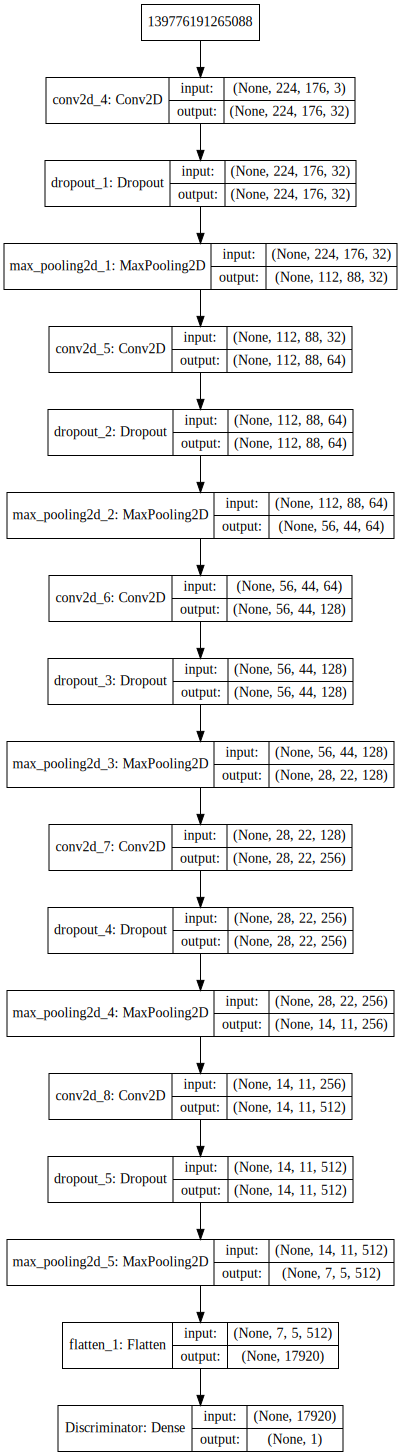

In [ ]:
discriminator = Sequential(name='Discriminator')

discriminator.add(Conv2D(input_shape=(224, 176, 3),filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
# discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.2))
discriminator.add(MaxPooling2D(pool_size=(2,2)))

discriminator.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
# discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.2))
discriminator.add(MaxPooling2D(pool_size=(2,2)))

discriminator.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
# discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.2))
discriminator.add(MaxPooling2D(pool_size=(2,2)))

discriminator.add(Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
# discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.2))
discriminator.add(MaxPooling2D(pool_size=(2,2)))

discriminator.add(Conv2D(512, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
# discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.2))
discriminator.add(MaxPooling2D(pool_size=(2,2)))

discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid',name='Discriminator'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)
discriminator.summary()
display(SVG(model_to_dot(discriminator,show_layer_names=True,show_shapes=True).create(prog='dot', format='svg')))


# Combined = GAN

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_input (InputLayer) (None, 100)               0         
_________________________________________________________________
Generator (Sequential)       (None, 224, 176, 3)       2014435   
_________________________________________________________________
Discriminator (Sequential)   (None, 1)                 1586497   
Total params: 3,600,932
Trainable params: 2,014,435
Non-trainable params: 1,586,497
_________________________________________________________________


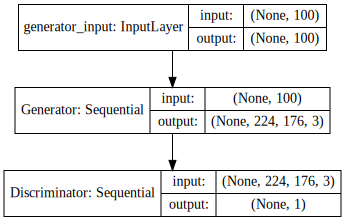

In [ ]:

discriminator.trainable = False
ganInput = Input(shape=(randomDim,),name='generator_input')
x = generator(ganInput)
# print(x.shape)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput, name='GAN')
# gan.layers[1].name = "Generator_Network"
# gan.layers[2].name = "Discriminator_Network"
gan.compile(loss='binary_crossentropy', optimizer=adam)
gan.summary()
display(SVG(model_to_dot(gan,show_layer_names=True,show_shapes=True).create(prog='dot', format='svg')))


# helper functions

In [ ]:
dLosses = []
gLosses = []

def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('images/gan_cnn_original_faces/dcgan_%d_loss_epoch.png' % epoch)

def plotGeneratedImages(epoch, examples=100, dim=(1, 1), figsize=(2, 2)):
    randomDim = 100
#     examples=1
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generatedImages = generator.predict(noise)
#     print(generatedImages.shape)
#     generatedImages = generatedImages*255.0 + 255.0
#     print(generatedImages.min(),generatedImages.max())
    fig = plt.figure(figsize=(10,2))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
    for i in range(10):
        ax = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
        ax.imshow(generatedImages[i][:,:,::-1])
    fol = 'images/gan_cnn_original_faces/faces/'
    if not os.path.exists(fol):
        os.makedirs(fol)
    plt.savefig(fol+'random_{:05d}.png'.format(epoch))
    
    
def saveModels(epoch):
    fol = 'models/gan_cnn_original_faces/'
    if not os.path.exists(fol):
        os.makedirs(fol)
    generator.save(fol+'dcgan_generator_epoch_%d.h5' % epoch)
    discriminator.save(fol+'dcgan_discriminator_epoch_%d.h5' % epoch)

# Training Code

In [ ]:



def train(epochs=1, batchSize=128, number_of_steps = 10):
    
    print ('Epochs:', epochs)
    print ('Batch size:', batchSize)
    print ('steps per epoch:',number_of_steps)
    datagenObj = datagen(batchSize,inputData)
    for e in tqdm(range(1, epochs+1)):
#         print ('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in range(number_of_steps):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            imageBatch = next(datagenObj)
            generatedImages = generator.predict(noise)
            X = np.concatenate([imageBatch, generatedImages])
            yDis = np.zeros(2*batchSize)
            # One-sided label smoothing
            yDis[:batchSize] = 0.9

            # Train discriminator
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yDis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            yGen = np.ones(batchSize)
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, yGen)

        # Store loss of most recent batch from this epoch
        dLosses.append(dloss)
        gLosses.append(gloss)

        if e == 1 or e % 100 == 0:
            plotGeneratedImages(e)
            saveModels(e)

    # Plot losses from every epoch
    plotLoss(e)

if __name__ == '__main__':
    print("")
    train(10000, 64, 1)



  0%|          | 0/10000 [00:00<?, ?it/s]


Epochs: 10000
Batch size: 64
steps per epoch: 1


  7%|▋         | 667/10000 [05:50<1:21:42,  1.90it/s]

In [ ]:
datagenObj = datagen(batchSize,inputData)

In [ ]:
for i in range(1):
    x = next(datagenObj)
    plt.imshow(x[0][:,:,::-1])
    print(x[0][:,:,::-1].shape)

In [ ]:
for i in x:
    plt.imshow(i)

In [ ]:
# from keras.utils import plot_model
# plot_model(model,ex to_file='model.png')

In [ ]:
examples=100
dim=(1, 1)
figsize=(2, 2)
noise = np.random.normal(0, 1, size=[examples, randomDim])
generatedImages = generator.predict(noise)
#     generatedImages = generatedImages*255.0 + 255.0
#     print(generatedImages.min(),generatedImages.max())
fig = plt.figure(figsize=(10,2))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(10):
    ax = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(generatedImages[i])

In [ ]:
# datagenObj = datagen(2,inputData)

In [ ]:
# x = next(datagenObj)

In [ ]:
'random_{:05d}.png'.format(9999)